In [1]:
import pandas as pd 
import numpy as np 
import os

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import keras

import warnings
warnings.filterwarnings("ignore")

In [ ]:
tf.keras.models.load_model('saved_model/my_model')

In [2]:
categories = [str(x) for x in range(1,101)]
train_path = "UECFOOD100_CROP/UECFOOD100_CROP/train"
test_path =  "UECFOOD100_CROP/UECFOOD100_CROP/test"
multiple_labels_path = "labels/multiple_food.txt"
multiple_food = pd.DataFrame()

mlb = MultiLabelBinarizer(categories)

def build_multiple_food_df():
    with open(multiple_labels_path) as f:
        contents = f.read().split('\n')
        labels = []
        images = []
        for content in contents[1:]:
            label = content.split(" ")[1:]
            label = label[:len(label)-1]
            labels.append(label)
            images.append(content.split(" ")[0])

        multiple_food["image"] = images
        multiple_food["labels"] = labels

def build_category_files(df_path):
    category_files = []
    for category in categories:
        category_path = os.path.join(df_path, str(category))
        category_files = category_files + [os.path.join(str(category), i) for i in os.listdir(category_path) if os.path.isfile(os.path.join(category_path,i))]
    return category_files
        
def build_category_labels(category_files):
    category_labels = []
    for file in category_files:
        number = file.split("\\")[1].split(".jpg")[0]
        category = file.split("\\")[0]
        multiple = multiple_food[multiple_food['image'] == number]
        labels = []
        if len(multiple) > 0:
            labels = mlb.fit_transform(list(multiple_food[multiple_food['image'] == number]["labels"]))
        else:
            labels = mlb.fit_transform(list([[category]]))
        category_labels.append(labels[0])
    return category_labels
    


In [3]:
build_multiple_food_df()
print("Length of Multiple Food: " + str(len(multiple_food)))

Length of Multiple Food: 1174


In [4]:
# Train Images
train_category_files = build_category_files(train_path)
train_category_labels = build_category_labels(train_category_files)
train_df = pd.DataFrame(train_category_labels, columns=categories)
train_df["filename"] = train_category_files

# Test Images
test_category_files = build_category_files(test_path)
test_category_labels = build_category_labels(test_category_files)
test_df = pd.DataFrame(test_category_labels, columns=categories)
test_df["filename"] = test_category_files

In [5]:
print(train_df.shape)
print(test_df.shape)

(11514, 101)
(2902, 101)


In [6]:
train_df.head()

,1,2,3,4,5,6,7,8,9,10,...,92,93,94,95,96,97,98,99,100,filename
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1\1.jpg
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1\10572.jpg
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1\10586.jpg
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1\10618.jpg
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1\10621.jpg


In [7]:
test_df.head()

,1,2,3,4,5,6,7,8,9,10,...,92,93,94,95,96,97,98,99,100,filename
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1\10.jpg
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1\10617.jpg
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1\10740.jpg
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1\11134.jpg
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1\11161.jpg


## Image Loader and Augmentation

In [6]:
datagen=ImageDataGenerator(rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        validation_split=0.2)

In [7]:
train_generator=datagen.flow_from_dataframe(
dataframe=train_df,
directory="./UECFOOD100_CROP/UECFOOD100_CROP/train",
x_col="filename",
y_col=categories,
batch_size=32,
seed=42,
shuffle=True,
class_mode="raw",
target_size=(128,128),
subset="training"
)

Found 9212 validated image filenames.


In [8]:
test_gen=ImageDataGenerator(rescale=1./255)

validation_generator=datagen.flow_from_dataframe(
dataframe=train_df,
directory="./UECFOOD100_CROP/UECFOOD100_CROP/train",
x_col="filename",
y_col=categories,
batch_size=32,
seed=42,
shuffle=True,
class_mode="raw",
target_size=(128,128),
subset="validation")

test_generator=test_gen.flow_from_dataframe(
dataframe=test_df,
directory="./UECFOOD100_CROP/UECFOOD100_CROP/test",
x_col="filename",
y_col=categories,
batch_size=32,
seed=42,
shuffle=True,
class_mode="raw",
target_size=(128,128))

Found 2302 validated image filenames.
Found 2902 validated image filenames.


## Model Training

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers, utils

from tensorflow.keras.layers import Dense, Dropout, Flatten 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, AveragePooling2D
from tensorflow.keras.optimizers import Adam
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications import ResNet50 
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import models
from tensorflow.keras.layers import Input
import tensorflow as tf
import matplotlib.pyplot as plt

In [10]:
from keras import backend as K
import keras_metrics as km

### InceptionV3

In [11]:
optimizer = Adam(learning_rate = .001)

inception = InceptionV3(weights='imagenet', include_top=False)

for layer in inception.layers:
    layer.trainable = False
    
x = inception.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(2048,activation='relu')(x)
x = Dense(2048,activation='relu')(x)
x = Dense(2048,activation='relu')(x)
x = Dense(2048,activation='relu')(x)

predictions = Dense(100,kernel_regularizer=regularizers.l2(0.005), activation='sigmoid')(x)
model = models.Model(inputs=inception.input, outputs=predictions)
model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['categorical_accuracy', 'binary_accuracy', 
                                                                             'top_k_categorical_accuracy', km.binary_precision(),
                                                                             km.binary_recall()])
model.summary()

#early stopping to monitor the validation loss and avoid overfitting
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)

#reducing learning rate on plateau
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience= 5, factor= 0.5, min_lr= 1e-6, verbose=1)


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [14]:
!python --version
import tensorflow as tf
print("Num GPUs Available", len(tf.config.experimental.list_physical_devices('GPU')))

Python 3.8.8
Num GPUs Available 1


In [74]:
model.evaluate(test_generator)

91/91 [==============================] - 9s 83ms/step - loss: 1.7621 - categorical_accuracy: 0.0090 - binary_accuracy: 0.4045 - top_k_categorical_accuracy: 0.0445 - precision: 0.0606 - recall: 0.0227


[1.7620588541030884,
 0.008959338068962097,
 0.4044761657714844,
 0.04445210099220276,
 0.06063481792807579,
 0.022700510919094086]

In [16]:
model.evaluate(train_generator)

360/360 [==============================] - 91s 252ms/step - loss: 2.1533 - binary_accuracy: 0.4270


[2.1532695293426514, 0.4269846975803375]

In [12]:
#With training and validation data
history1 = model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=50,
                    verbose=True,  callbacks=[early_stop, rlrop]
)

Epoch 1/50
288/288 [==============================] - 124s 399ms/step - loss: 0.1615 - categorical_accuracy: 0.0784 - binary_accuracy: 0.9853 - top_k_categorical_accuracy: 0.2091 - precision: 0.2987 - recall: 0.1706 - val_loss: 0.0917 - val_categorical_accuracy: 0.0834 - val_binary_accuracy: 0.9861 - val_top_k_categorical_accuracy: 0.2085 - val_precision: 0.5827 - val_recall: 0.3103
Epoch 2/50
288/288 [==============================] - 108s 376ms/step - loss: 0.0645 - categorical_accuracy: 0.1365 - binary_accuracy: 0.9871 - top_k_categorical_accuracy: 0.3446 - precision: 0.6193 - recall: 0.3355 - val_loss: 0.0832 - val_categorical_accuracy: 0.1751 - val_binary_accuracy: 0.9864 - val_top_k_categorical_accuracy: 0.2611 - val_precision: 0.6391 - val_recall: 0.3540
Epoch 3/50
288/288 [==============================] - 125s 434ms/step - loss: 0.0586 - categorical_accuracy: 0.1847 - binary_accuracy: 0.9872 - top_k_categorical_accuracy: 0.4421 - precision: 0.6545 - recall: 0.3705 - val_loss: 

Epoch 17/50
288/288 [==============================] - 112s 389ms/step - loss: 0.0415 - categorical_accuracy: 0.4072 - binary_accuracy: 0.9891 - top_k_categorical_accuracy: 0.7048 - precision: 0.7314 - recall: 0.4436 - val_loss: 0.0795 - val_categorical_accuracy: 0.1429 - val_binary_accuracy: 0.9858 - val_top_k_categorical_accuracy: 0.2407 - val_precision: 0.7329 - val_recall: 0.4476
Epoch 18/50
288/288 [==============================] - 77s 266ms/step - loss: 0.0411 - categorical_accuracy: 0.4239 - binary_accuracy: 0.9892 - top_k_categorical_accuracy: 0.7055 - precision: 0.7346 - recall: 0.4518 - val_loss: 0.0802 - val_categorical_accuracy: 0.1290 - val_binary_accuracy: 0.9859 - val_top_k_categorical_accuracy: 0.2459 - val_precision: 0.7367 - val_recall: 0.4556
Epoch 19/50
288/288 [==============================] - 55s 192ms/step - loss: 0.0407 - categorical_accuracy: 0.4281 - binary_accuracy: 0.9893 - top_k_categorical_accuracy: 0.7095 - precision: 0.7380 - recall: 0.4587 - val_loss:

In [ ]:
# precision is indicating if model tendency to predict 0 as 1 (False positive) 
# recall is indicating if model tendency to predict 1 as 0 (False Negative) => this is more likely to happen than the above

In [15]:
np.save('model_histories/history1_inceptv3.npy',history1.history)

In [16]:
history1=np.load('model_histories/history1_inceptv3.npy',allow_pickle='TRUE').item()

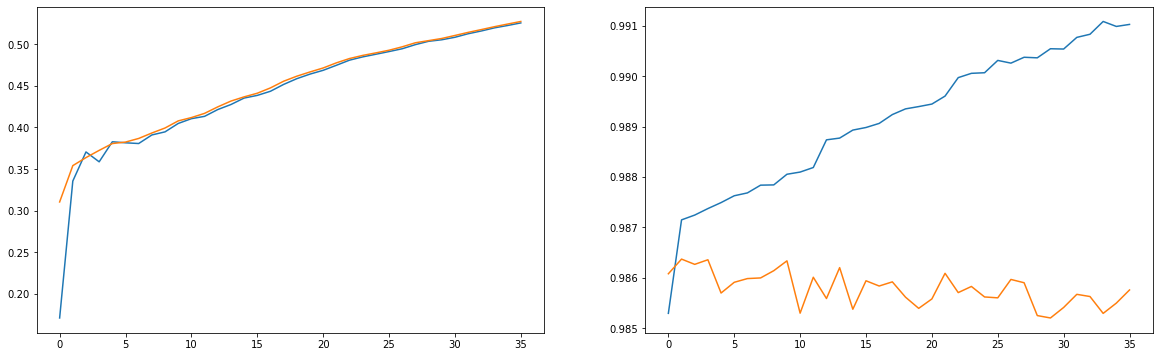

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))
axes[0].plot(history1['recall'])
axes[0].plot(history1['val_recall'])
axes[1].plot(history1['binary_accuracy'])
axes[1].plot(history1['val_binary_accuracy'])

In [29]:
# serialize model to JSON
model_json = model.to_json()
with open("uec100_inceptv3.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("uec100_inceptv3.h5")
print("Saved model to disk")



Saved model to disk


In [61]:
from keras.models import model_from_json
json_file = open('uec100_inceptv3.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("uec100_inceptv3.h5")
print("Loaded model from disk")

Loaded model from disk


In [60]:
test_generator.reset()
pred=model.predict_generator(test_generator,
verbose=1)

pred_bool = (pred >0.5)
predictions = pred_bool.astype(int)
results=pd.DataFrame(predictions, columns=categories)
results["filename"]=test_generator.filenames
ordered_cols=["filename"]+categories
results=results[ordered_cols]#To get the same column order

47/91 [==============>...............] - ETA: 3s

KeyboardInterrupt: 

In [68]:
img =load_img('web_pics/fastfood_meal.jpg', target_size=(128,128))

35


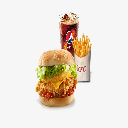

In [69]:
preds = loaded_model.predict(np.array([img_to_array(img)/255]))
print(np.argmax(preds[0]))
img

## ResNet

In [42]:
optimizer = Adam(learning_rate = .001)

resnet = ResNet50(weights='imagenet', include_top=False)

for layer in resnet.layers:
    layer.trainable = False
    
x = resnet.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(2048,activation='relu')(x)
x = Dense(2048,activation='relu')(x)
x = Dense(2048,activation='relu')(x)
x = Dense(2048,activation='relu')(x)

predictions = Dense(100,kernel_regularizer=regularizers.l2(0.005), activation='sigmoid')(x)
model = models.Model(inputs=resnet.input, outputs=predictions)
model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['categorical_accuracy', 'binary_accuracy', 
                                                                             'top_k_categorical_accuracy', km.binary_precision(),
                                                                             km.binary_recall()])
model.summary()

#early stopping to monitor the validation loss and avoid overfitting
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)

#reducing learning rate on plateau
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience= 5, factor= 0.5, min_lr= 1e-6, verbose=1)


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [20]:
model.evaluate(test_generator)

91/91 [==============================] - 15s 147ms/step - loss: 1.6700 - binary_accuracy: 0.4445


[1.6699771881103516, 0.44454512000083923]

In [43]:
#With training and validation data
history2 = model.fit(train_generator, validation_data=validation_generator,epochs=50, verbose=True,  callbacks=[early_stop, rlrop])

Epoch 1/50
288/288 [==============================] - 59s 196ms/step - loss: 0.1552 - categorical_accuracy: 0.0422 - binary_accuracy: 0.9851 - top_k_categorical_accuracy: 0.1493 - precision: 0.0721 - recall: 0.0420 - val_loss: 0.0969 - val_categorical_accuracy: 0.0000e+00 - val_binary_accuracy: 0.9858 - val_top_k_categorical_accuracy: 0.0652 - val_precision: 0.0787 - val_recall: 0.0073
Epoch 2/50
288/288 [==============================] - 56s 194ms/step - loss: 0.0709 - categorical_accuracy: 0.0518 - binary_accuracy: 0.9869 - top_k_categorical_accuracy: 0.1632 - precision: 0.0799 - recall: 0.0047 - val_loss: 0.0836 - val_categorical_accuracy: 0.2094 - val_binary_accuracy: 0.9859 - val_top_k_categorical_accuracy: 0.2146 - val_precision: 0.1478 - val_recall: 0.0074
Epoch 3/50
288/288 [==============================] - 56s 195ms/step - loss: 0.0678 - categorical_accuracy: 0.0528 - binary_accuracy: 0.9870 - top_k_categorical_accuracy: 0.1690 - precision: 0.2025 - recall: 0.0091 - val_loss:

Epoch 17/50
288/288 [==============================] - 56s 195ms/step - loss: 0.0629 - categorical_accuracy: 0.0744 - binary_accuracy: 0.9870 - top_k_categorical_accuracy: 0.2133 - precision: 0.5135 - recall: 0.0228 - val_loss: 0.0830 - val_categorical_accuracy: 0.0317 - val_binary_accuracy: 0.9859 - val_top_k_categorical_accuracy: 0.1872 - val_precision: 0.5182 - val_recall: 0.0233
Epoch 18/50
288/288 [==============================] - 56s 196ms/step - loss: 0.0628 - categorical_accuracy: 0.0747 - binary_accuracy: 0.9870 - top_k_categorical_accuracy: 0.2194 - precision: 0.5225 - recall: 0.0246 - val_loss: 0.0844 - val_categorical_accuracy: 0.0000e+00 - val_binary_accuracy: 0.9858 - val_top_k_categorical_accuracy: 0.1851 - val_precision: 0.5189 - val_recall: 0.0247
Epoch 19/50
288/288 [==============================] - 57s 200ms/step - loss: 0.0628 - categorical_accuracy: 0.0733 - binary_accuracy: 0.9869 - top_k_categorical_accuracy: 0.2264 - precision: 0.5133 - recall: 0.0250 - val_lo

In [44]:
np.save('model_histories/history2_resnet50.npy',history2.history)

In [45]:
history2=np.load('model_histories/history2_resnet50.npy',allow_pickle='TRUE').item()

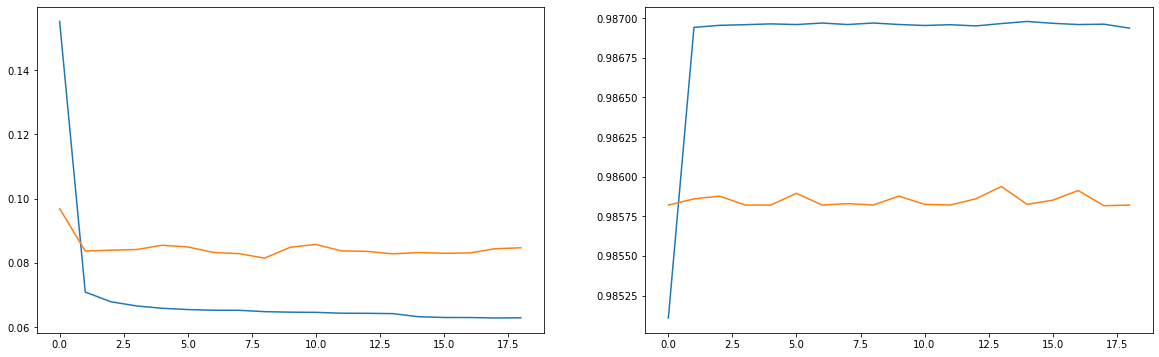

In [46]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))
axes[0].plot(history2['loss'])
axes[0].plot(history2['val_loss'])
axes[1].plot(history2['binary_accuracy'])
axes[1].plot(history2['val_binary_accuracy'])

In [47]:
# serialize model to JSON
model_json = model.to_json()
with open("uec100_resnet.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("uec100_resnet.h5")
print("Saved model to disk")

Saved model to disk


In [48]:
from keras.models import model_from_json
json_file = open('uec100_resnet.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("uec100_resnet.h5")
print("Loaded model from disk")

Loaded model from disk


In [31]:
test_generator.reset()
pred=model.predict_generator(test_generator,
verbose=1)

pred_bool = (pred >0.5)
predictions = pred_bool.astype(int)
results=pd.DataFrame(predictions, columns=categories)
results["filename"]=test_generator.filenames
ordered_cols=["filename"]+categories
results=results[ordered_cols]#To get the same column order

C:\Users\cheew\anaconda3\lib\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


91/91 [==============================] - 14s 149ms/step


In [42]:
model.evaluate(test_generator)

91/91 [==============================] - 14s 148ms/step - loss: 0.0643 - binary_accuracy: 0.9867


[0.06429946422576904, 0.9866511225700378]

In [34]:
img =load_img('web_pics/fishpastry.jpg', target_size=(128,128))

35


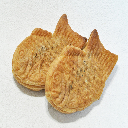

In [43]:
preds = model.predict(np.array([img_to_array(img)/255]))
preds = model.predict(np.array([img_to_array(img)/255]))
print(np.argmax(preds[0]))
img

## VGG16


In [14]:
optimizer = Adam(learning_rate = .001)

vgg = VGG16(weights='imagenet', include_top=False)

for layer in vgg.layers:
    layer.trainable = False
    
x = vgg.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(2048,activation='relu')(x)
x = Dense(2048,activation='relu')(x)
x = Dense(2048,activation='relu')(x)
x = Dense(2048,activation='relu')(x)
x = Dense(2048,activation='relu')(x)
x = Dense(2048,activation='relu')(x)
x = Dense(2048,activation='relu')(x)
x = Dense(2048,activation='relu')(x)
x = Dense(2048,activation='relu')(x)

predictions = Dense(100,kernel_regularizer=regularizers.l2(0.005), activation='sigmoid')(x)
model = models.Model(inputs=vgg.input, outputs=predictions)
model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['categorical_accuracy', 'binary_accuracy', 
                                                                             'top_k_categorical_accuracy', km.binary_precision(),
                                                                             km.binary_recall()])
model.summary()

#early stopping to monitor the validation loss and avoid overfitting
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)

#reducing learning rate on plateau
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience= 5, factor= 0.5, min_lr= 1e-6, verbose=1)


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0   

In [15]:
#With training and validation data
history3 = model.fit(train_generator, validation_data=validation_generator,epochs=50, verbose=True,  callbacks=[early_stop, rlrop])

Epoch 1/50
288/288 [==============================] - 53s 180ms/step - loss: 0.1764 - categorical_accuracy: 0.0429 - binary_accuracy: 0.9837 - top_k_categorical_accuracy: 0.1404 - precision: 0.1855 - recall: 0.0309 - val_loss: 0.1031 - val_categorical_accuracy: 0.0000e+00 - val_binary_accuracy: 0.9858 - val_top_k_categorical_accuracy: 0.2168 - val_precision: 0.1875 - val_recall: 0.0063
Epoch 2/50
288/288 [==============================] - 50s 175ms/step - loss: 0.0730 - categorical_accuracy: 0.0484 - binary_accuracy: 0.9870 - top_k_categorical_accuracy: 0.1534 - precision: 0.1875 - recall: 0.0039 - val_loss: 0.0841 - val_categorical_accuracy: 0.2168 - val_binary_accuracy: 0.9858 - val_top_k_categorical_accuracy: 0.2168 - val_precision: 0.1875 - val_recall: 0.0028
Epoch 3/50
288/288 [==============================] - 51s 176ms/step - loss: 0.0696 - categorical_accuracy: 0.0473 - binary_accuracy: 0.9870 - top_k_categorical_accuracy: 0.1630 - precision: 0.1875 - recall: 0.0022 - val_loss:


Epoch 00016: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 17/50
288/288 [==============================] - 49s 172ms/step - loss: 0.0581 - categorical_accuracy: 0.1175 - binary_accuracy: 0.9875 - top_k_categorical_accuracy: 0.2835 - precision: 0.7215 - recall: 0.2257 - val_loss: 0.0827 - val_categorical_accuracy: 0.0647 - val_binary_accuracy: 0.9870 - val_top_k_categorical_accuracy: 0.1885 - val_precision: 0.7266 - val_recall: 0.2351
Epoch 18/50
288/288 [==============================] - 49s 171ms/step - loss: 0.0573 - categorical_accuracy: 0.1297 - binary_accuracy: 0.9876 - top_k_categorical_accuracy: 0.3040 - precision: 0.7319 - recall: 0.2447 - val_loss: 0.0833 - val_categorical_accuracy: 0.0400 - val_binary_accuracy: 0.9868 - val_top_k_categorical_accuracy: 0.2020 - val_precision: 0.7364 - val_recall: 0.2528
Epoch 19/50
288/288 [==============================] - 49s 171ms/step - loss: 0.0569 - categorical_accuracy: 0.1343 - binary_accuracy: 0.9875 - top

In [51]:
np.save('model_histories/history3_VGG16.npy',history3.history)

In [52]:
history3=np.load('model_histories/history3_VGG16.npy',allow_pickle='TRUE').item()

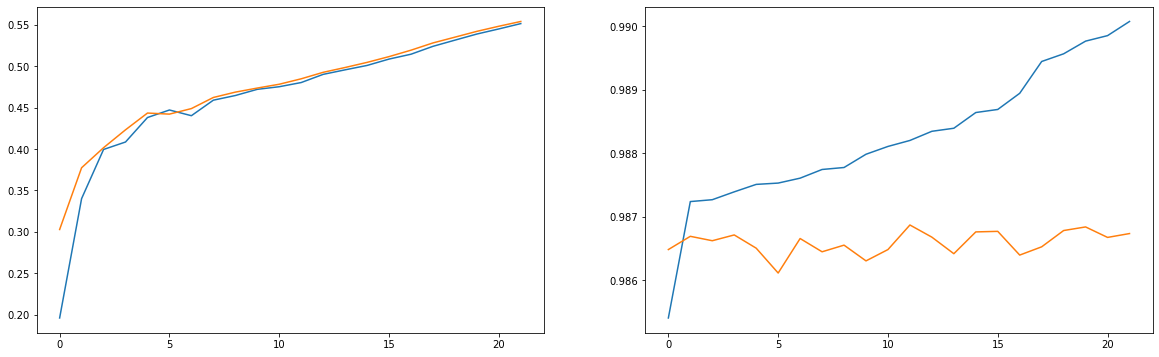

In [54]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))
axes[0].plot(history3['recall'])
axes[0].plot(history3['val_recall'])
axes[1].plot(history3['binary_accuracy'])
axes[1].plot(history3['val_binary_accuracy'])

In [49]:
model.evaluate(test_generator)

91/91 [==============================] - 13s 139ms/step - loss: 0.0468 - binary_accuracy: 0.9887


[0.04677757993340492, 0.9887419939041138]

In [55]:
# serialize model to JSON
model_json = model.to_json()
with open("uec100_VGG16.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("uec100_VGG16.h5")
print("Saved model to disk")

Saved model to disk


In [56]:
from keras.models import model_from_json
json_file = open('uec100_VGG16.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("uec100_VGG16.h5")
print("Loaded model from disk")

Loaded model from disk


In [55]:
test_generator.reset()
pred=model.predict_generator(test_generator,
verbose=1)

pred_bool = (pred >0.5)
predictions = pred_bool.astype(int)
results=pd.DataFrame(predictions, columns=categories)
results["filename"]=test_generator.filenames
ordered_cols=["filename"]+categories
results=results[ordered_cols]#To get the same column order

91/91 [==============================] - 13s 141ms/step


In [57]:
img =load_img('web_pics/fishpastry.jpg', target_size=(128,128))

77


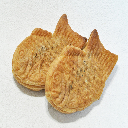

In [59]:
preds = loaded_model.predict(np.array([img_to_array(img)/255]))
print(np.argmax(preds[0]))
img

## Image Loader and Without Augmentation

In [58]:
no_augment_datagen=ImageDataGenerator(
        rescale=1./255,
        fill_mode='nearest')

train_gen_no_augment = no_augment_datagen.flow_from_dataframe(   
    dataframe=train_df,
    directory="./UECFOOD100_CROP/UECFOOD100_CROP/train",
    x_col="filename",
    y_col=categories,
    shuffle=False,
    batch_size=32,
    seed=42,
    class_mode="raw",
    target_size=(128,128))

test_gen_no_augment = no_augment_datagen.flow_from_dataframe(   
    dataframe=test_df,
    directory="./UECFOOD100_CROP/UECFOOD100_CROP/test",
    x_col="filename",
    y_col=categories,
    shuffle=False,
    batch_size=32,
    seed=42,
    class_mode="raw",
    target_size=(128,128))

Found 11514 validated image filenames.
Found 2902 validated image filenames.


## Multi Output